<a href="https://colab.research.google.com/github/olipa/lectures-labs/blob/master/Copie_de_ExerciseMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix factorization of an explicit feedback (ratings) matrix

The goal of this exercise is to generate recommendations for movies using Matrix Factorization (MF) and Neural Network MF. 

See also:
* https://arxiv.org/abs/1708.05031
* http://hameddaily.blogspot.fr/2016/12/simple-matrix-factorization-with.html
* https://nipunbatra.github.io/blog/2017/recommend-keras.html


In [0]:
!pip install -q tensorflow==2.0.0-beta0
!pip install -q matplotlib
!pip install -q pandas
!pip install -q numpy

     |████████████████████████████████| 87.9MB 94kB/s 
     |████████████████████████████████| 501kB 41.5MB/s 
     |████████████████████████████████| 3.1MB 41.1MB/s 


In [0]:
import tensorflow as tf
import numpy 
import pandas as pd
import matplotlib
%matplotlib inline

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


TensorFlow version: 2.0.0-beta0
Eager execution: True


### Load the data
The small MovieLens dataset: https://grouplens.org/datasets/movielens/100k/

In [0]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen("http://files.grouplens.org/datasets/movielens/ml-100k.zip")
zipfile = ZipFile(BytesIO(resp.read()))
file = 'ml-100k/u.data'
df = pd.read_csv(zipfile.open(file), low_memory=False, skiprows=[0], sep='\t', names=['user', 'item', 'rate', 'time'])
df.describe()

,user,item,rate,time
count,99999.000000,99999.000000,99999.000000,9.999900e+04
mean,462.487415,425.531965,3.529865,8.835289e+08
std,266.614421,330.799501,1.125678,5.343878e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,175.000000,3.000000,8.794487e+08
50%,447.000000,322.000000,4.000000,8.828269e+08
75%,682.000000,631.000000,4.000000,8.882600e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


We split the dataset into training and test subset. We remove the mean rating.  



In [0]:
numpy.random.seed(42)
# split data into train and test set
msk = numpy.random.rand(len(df)) < 0.7
df_train = df[msk]
df_test = df[~msk]

user_index = [x-1 for x in df_train.user.values]
item_index = [x-1 for x in df_train.item.values]
user_index_test = [x-1 for x in df_test.user.values]
item_index_test = [x-1 for x in df_test.item.values]

rates = df_train.rate.values 
rates_test = df_test.rate.values

num_ratings = len(rates)
num_ratings_test = len(rates_test)
mean_rating = numpy.mean(rates)
mean_rating_test = numpy.mean(rates_test)

rates = rates - mean_rating
rates_test = rates_test - mean_rating

print ("Mean (train) rating = " + str(mean_rating))
print ("Number of ratings (train/val/total) = " + str(num_ratings) + "/" + str(num_ratings_test) + "/" + str(num_ratings + num_ratings_test))

Mean (train) rating = 3.528654970760234
Number of ratings (train/val/total) = 70110/29889/99999


# Matrix Factorization

In matrix factorization user rating r is formulated as an inner product of two latent vectors $u$ and $v$  which are two latent vectors in same space to represent the user interest and movie feature respectively.

$r=u^Tv$ 


In [0]:
len(numpy.unique(df.item.values))

1682

In [0]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://4.bp.blogspot.com/-95QD5t9Lha4/Wd7uWnBZBeI/AAAAAAAADg4/xB4VnnxM0UgUp15lNmB3aHCXYGejpm4OACLcBGAs/s1600/matrix_factorization.png")

### Latent space

We define these two latent variables in TensorFlow as follows: $U$ shows latent representation of user interest and $P$ that represents the latent values for items.

The dimension of the latent space 'feature_len' is a parameter of the method.


In [0]:
# variables
feature_len = 100

num_users = len(numpy.unique(df.user.values)) 
num_items = len(numpy.unique(df.item.values)) 

print("Number of users is {}".format(num_users))
print("Number of movies is {}".format(num_items))
print("The latent space has dimension {}".format(feature_len))


Number of users is 943
Number of movies is 1682
The latent space has dimension 100


### Model
We define the user and item matrices and use their product to compute ratings R. 


In [0]:
# product embedding
item_input = tf.keras.layers.Input(shape=[1],name='Item')
item_embedding = tf.keras.layers.Embedding(num_items, feature_len, name='Item-Embedding')(item_input)
item_vec = tf.keras.layers.Flatten(name='FlattenItems')(item_embedding)

# user embedding
user_input = tf.keras.layers.Input(shape=[1],name='User')
user_embedding = tf.keras.layers.Embedding(num_users, feature_len, name='User-Embedding')(user_input)
user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)

# rating
#user_vec_transp = tf.transpose(user_vec)
result = tf.keras.layers.dot([item_vec, user_vec], axes=1, name='DotProduct')

# initialize Keras model 
model = tf.keras.Model([user_input, item_input], result)
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 100)       168200      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 100)       94300       User[0][0]                       
____________________________________________________________________________________________

### Loss and optimizer

To learn model parameters, we optimize the model with respect to mean squared error loss. As the optimization algorithm we use stochastic gradient descent (SGD) or Adam optimizer.


In [0]:
loss = tf.keras.losses.MeanSquaredError()

# learning rate
lr = 0.001
learning_rate = tf.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000,
    decay_rate=0.96, staircase=True)

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.optimizers.SGD(learning_rate=lr)


### Metrics
We define the accuracy metric.

In [0]:
# Define accuracy
threshold = 1.0

def accuracy(desired_rates, predicted_rates):
    diff_op = tf.subtract(predicted_rates, desired_rates, name='trainig_diff')
    # Just measure the absolute difference against the threshold
    good = tf.less(tf.abs(diff_op), threshold)

    return tf.reduce_mean(tf.cast(good, tf.float32))


### Compile the Keras model

In [0]:
# compile the model with the optimizerm, loss and the tracking metrics
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])


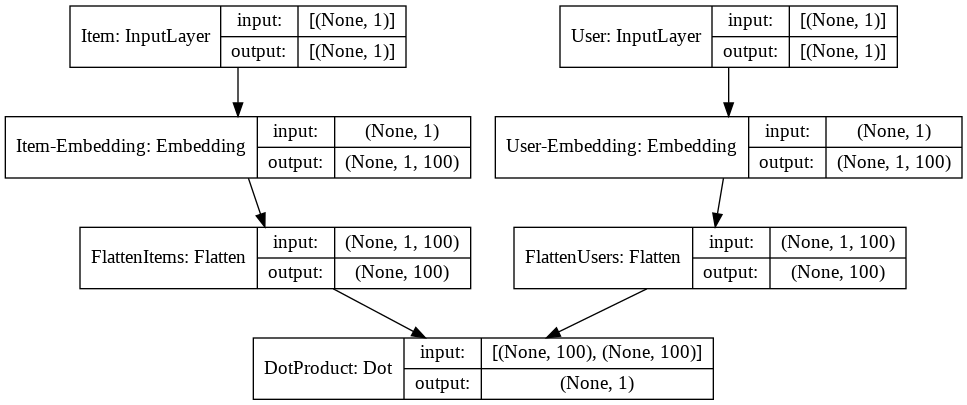

In [0]:
tf.keras.utils.plot_model(model,to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

### Training

During training, we evaluate the accuracy on a validation set (validation_split=0.1).

Question: Choose the number of epochs such that the model does not overfit the training set.


In [0]:
numberEpochs = 10
history = model.fit([user_index, item_index], rates, epochs=numberEpochs, verbose=1, validation_split=0.1)


Train on 63099 samples, validate on 7011 samples
Epoch 1/10
63099/63099 [==============================] - 3s 48us/sample - loss: 0.5848 - accuracy: 0.8234 - val_loss: 0.9496 - val_accuracy: 0.7184
Epoch 2/10
63099/63099 [==============================] - 3s 42us/sample - loss: 0.5699 - accuracy: 0.8283 - val_loss: 0.9606 - val_accuracy: 0.7150
Epoch 3/10
63099/63099 [==============================] - 3s 43us/sample - loss: 0.5561 - accuracy: 0.8326 - val_loss: 0.9725 - val_accuracy: 0.7118
Epoch 4/10
63099/63099 [==============================] - 3s 43us/sample - loss: 0.5444 - accuracy: 0.8375 - val_loss: 0.9841 - val_accuracy: 0.7083
Epoch 5/10
63099/63099 [==============================] - 3s 43us/sample - loss: 0.5342 - accuracy: 0.8406 - val_loss: 0.9951 - val_accuracy: 0.7084
Epoch 6/10
63099/63099 [==============================] - 3s 42us/sample - loss: 0.5256 - accuracy: 0.8441 - val_loss: 1.0050 - val_accuracy: 0.7053
Epoch 7/10
63099/63099 [==============================] -

### Visualize the training history
We can visualize the training and validation loss.

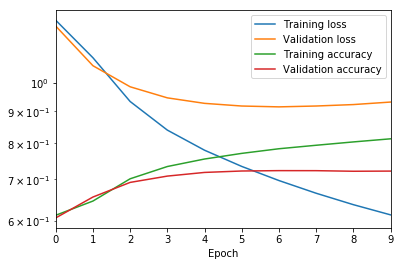

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
    pd.Series(history.history['loss']).plot(logy=True, label='Training loss')
    pd.Series(history.history['val_loss']).plot(logy=True, label='Validation loss')
    
    pd.Series(history.history['accuracy']).plot(logy=True, label='Training accuracy')
    pd.Series(history.history['val_accuracy']).plot(logy=True, label='Validation accuracy')
    plt.legend()

    plt.xlabel("Epoch")

    plt.show()
    
plot_history(history)

### Evaluation on the test dataset
Let's look at the predictions for some users from the testset. We also compute MAE on the testset.




In [0]:
# example
nr_sampled_users = 10

for index in numpy.random.choice(range(len(user_index_test)), size=nr_sampled_users):
    u = [user_index_test[index]]
    p = [item_index_test[index]]
    r = rates_test[index] + mean_rating

    rhat = model.predict([u, p]) + mean_rating_test

    print ("rating for user " + str(u) + " for item " + str(p) + " is " + str(r) + " and our prediction is: " + str(rhat[0]))


rating for user [359] for item [325] is 3.0 and our prediction is: [3.015556]
rating for user [794] for item [180] is 4.0 and our prediction is: [3.0877047]
rating for user [869] for item [1040] is 2.0 and our prediction is: [3.2914193]
rating for user [571] for item [812] is 4.0 and our prediction is: [4.6077695]
rating for user [312] for item [447] is 3.0 and our prediction is: [3.2677693]
rating for user [888] for item [686] is 2.0 and our prediction is: [2.1787255]
rating for user [456] for item [175] is 5.0 and our prediction is: [4.671523]
rating for user [296] for item [180] is 4.0 and our prediction is: [3.6828446]
rating for user [404] for item [574] is 5.0 and our prediction is: [2.6576185]
rating for user [317] for item [516] is 3.0 and our prediction is: [3.931131]


In [0]:
from sklearn.metrics import mean_absolute_error

def compute_error(model, user_index_test, item_index_test):
    predicted_rates_test = model.predict([user_index_test, item_index_test])
    
    return mean_absolute_error(rates_test, predicted_rates_test)

err_test = compute_error(model, user_index_test, item_index_test)
print("Mean absolute error on the test set: {}".format(err_test))


Mean absolute error on the test set: 0.8004533224410546


### Generate recommendations from the trained model for a list of users

Noe that we have trained a model to predict ratings, we generate recommendations for every user by ranking the movies by the predicted rating.


In [0]:
def create_recommendations(model, df, listOfUsers, nrRecommendations=20):
    
    item_index = numpy.array(numpy.unique(df.item.values))-1
    recommendations_set = {}
    
    for user in listOfUsers:
        user_index = numpy.ones(len(item_index)) * user
        predicted_rates = model.predict([user_index, item_index]) #+ mean_rating
        
        ranked_items_idx = numpy.argsort(predicted_rates, axis=0)[::-1].squeeze()
        ranked_items = item_index[ranked_items_idx] 
        recommendations_set[user] = ranked_items[:nrRecommendations]
        
    return recommendations_set


### Create validation set for every user
We first create a validation set for every user which consists of all the products that the user rated higher than 3.5 (the value of the mean rate).


In [0]:
def create_validation_set(df, minRate=3.5, k=5):
    validation_set = {}
    
    for user in numpy.unique(df['user'].values) - 1:
        rated_items = df[df['user'] == user]['item'].values -1
        rates = df[df['user'] == user]['rate'].values

        best_ranked_items = rated_items[numpy.where(rates > minRate)[0]]
        if len(best_ranked_items) >= k:
            validation_set[user] = best_ranked_items
            
    return validation_set


### Compute precision@k 

In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

Precision at k is the proportion of recommended items in the top-k set that are relevant.



In [0]:
def precisionAtK(validations_set, recommendations_set, k=5):
    
    res = []
    for user in validations_set.keys():
        
        v = validations_set[user]
        r = recommendations_set[user][:k]
        
        ans = len(numpy.intersect1d(v, r)) / k
        res.append(ans)

    return numpy.mean(res)


In [0]:
def compute_precisionAtK_from_recommendations(model, df_test, validation_set=None, nrRecommendations=20, k=10):
    """
    Compute precisionAtK from recommendations and validation set. Generate recommendations applying \
    'model' to dataset 'df_test'. 
    """
    if validation_set is None:
        validation_set = create_validation_set(df_test, minRate=3.5, k=k)
        
    recommendations_set = create_recommendations(model, df_test, \
                                              validation_set.keys(), nrRecommendations=nrRecommendations)
    precision = precisionAtK(validation_set, recommendations_set, k=k)
    
    return precision



In [0]:
k = 5

validation_set = create_validation_set(df_test, minRate=3.5, k=k)

precision = compute_precisionAtK_from_recommendations(model, df_test, validation_set=validation_set, \
                                                      nrRecommendations=20, k=k)
print("MF: Precision@{} is {}".format(k, precision))


MF: Precision@5 is 0.028720626631853787


## Exercise
Experiment with the parameter choice of the MF model and evaluate the setting in MAE and Precision@5. Compare various settings in the ResultsTable.

In [0]:
class ResultsTable():
    def __init__(self):
        self.columns = ["name", "MAE", "Precision@5"]
        self.df = pd.DataFrame(columns=self.columns)
        
    def add(self, name="experimentName", mae=None, precision=None, overwrite=False):
        
        data ={"name":name, "MAE":mae, "Precision@5": precision}
        res = pd.Series(data, self.columns, name=name)
        
        if len(self.df[self.df.name == name]) > 0:
            if not overwrite:
                raise Exception("Error: experiments name already exists. Change the name or set overwrite to True.")
            else:
                self.df = self.df.drop(self.df[self.df.name == name].index[0])
                self.df = self.df.append(res,  ignore_index=True)

        else:
            self.df = self.df.append(res,  ignore_index=True)

        
    def show(self):
        display(self.df)

table = ResultsTable()        


Compute the MAE and Precision@5.

In [0]:
err_test = compute_error(model, user_index_test, item_index_test)

precision = compute_precisionAtK_from_recommendations(model, df_test, validation_set=validation_set, nrRecommendations=20, k=5)
print("MF: Precision@{} is {}".format(5, precision))
print("MF: MAE is {}".format(err_test))

table.add(name="MF", mae=err_test, precision=precision, overwrite=True)
table.show()



In [0]:
## example:
experiment_name = "MF_" + "regUserItemL2"


### Question: 
- choose the regularization
 https://keras.io/regularizers/
- loss 
- optimizer
- learning rate
- number of epochs

Benchmark several experiments with different hyperparameters 



In [0]:
# regularizers
no_regularizer = None
regularizer_l2 = tf.keras.regularizers.l2(0.0001)
regularizer_l1 = tf.keras.regularizers.l1(0.0001)
regularizer_l1l2 = tf.keras.regularizers.l1_l2(0.0001)

regularizer_user = regularizer_l2
regularizer_product = regularizer_l2


In [0]:
# product embedding
item_input = tf.keras.layers.Input(shape=[1],name='Item')

################ EMBEDDING AND REGULARIZER ##########################################################################
item_embedding = tf.keras.layers.Embedding(num_items, feature_len, name='Item-Embedding', \
                                          embeddings_regularizer=regularizer_product)(item_input)
#################################################################################################

item_vec = tf.keras.layers.Flatten(name='FlattenItems')(item_embedding)

# user embedding
user_input = tf.keras.layers.Input(shape=[1],name='User')
################ EMBEDDING AND REGULARIZER ##########################################################################
user_embedding = tf.keras.layers.Embedding(num_users, feature_len,name='User-Embedding', \
                                          embeddings_regularizer=regularizer_user)(user_input)
#################################################################################################

user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)

# rating
result = tf.keras.layers.dot([item_vec, user_vec], axes=1, name='DotProduct')

# initialize Keras model 
model = tf.keras.Model([user_input, item_input], result)
#model.summary()


In [0]:
# choose the loss 
# see https://keras.io/losses/
loss = tf.keras.losses.MeanSquaredError()

# learning rate
lr = 0.001
learning_rate = tf.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000,
    decay_rate=0.96, staircase=True)

# choose the optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.optimizers.SGD(learning_rate=lr)


# compile the model with the optimizerm, loss and the tracking metrics
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

#model.summary()

numberEpochs = 10
history = model.fit([user_index, item_index], rates, epochs=numberEpochs, verbose=1, validation_split=0.1)
plot_history(history)


MAE

In [0]:
err_test = compute_error(model, user_index_test, item_index_test)

precision = compute_precisionAtK_from_recommendations(model, df_test, validation_set=validation_set, \
                                                      nrRecommendations=20, k=5)
print("MF: Precision@{} is {}".format(5, precision))
print("MF: MAE is {}".format(err_test))



In [0]:
table.add(name=experiment_name, mae=err_test, precision=precision, overwrite=True)
table.show()


In [0]:
#table.add(name="experiment_l1regularization", mae=err_test, precision=precision)
table.show()


# Neural networks for recommendation
Create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

- Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
- We can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.

In [0]:
experiment_name = "NNMF"


In [0]:
n_latent_factors_user = 50
n_latent_factors_item = 100

item_input = tf.keras.layers.Input(shape=[1],name='Item')
item_embedding = tf.keras.layers.Embedding(num_items, n_latent_factors_item, name='Item-Embedding')(item_input)
item_vec = tf.keras.layers.Flatten(name='FlattenItems')(item_embedding)
item_vec = tf.keras.layers.Dropout(0.2)(item_vec)

user_input = tf.keras.layers.Input(shape=[1],name='User')
user_embedding = tf.keras.layers.Embedding(num_users, n_latent_factors_user,name='User-Embedding')(user_input)
user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec = tf.keras.layers.Dropout(0.2)(user_vec)

concat = tf.keras.layers.concatenate([item_vec, user_vec], name='Concat')
concat = tf.keras.layers.Dropout(0.2)(concat)
full1 = tf.keras.layers.Dense(200,name='FullyConnected', activation='relu')(concat)
full1 = tf.keras.layers.Dropout(0.2,name='Dropout')(full1)
full2 = tf.keras.layers.Dense(100,name='FullyConnected-1', activation='relu')(full1)
full2 = tf.keras.layers.Dropout(0.2,name='Dropout')(full2)
full3 = tf.keras.layers.Dense(50,name='FullyConnected-2', activation='relu')(full2)
full3 = tf.keras.layers.Dropout(0.2,name='Dropout')(full3)
full4 = tf.keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(full3)

result = tf.keras.layers.Dense(1, name='Activation')(full1)

lr = 0.0001
learning_rate = tf.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000,
    decay_rate=0.96, staircase=True)

adam = tf.optimizers.Adam(learning_rate=learning_rate)
model_NN = tf.keras.Model([user_input, item_input], result)
model_NN.compile(optimizer=adam, loss= 'mean_squared_error', metrics=[accuracy])
model_NN.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 100)       168200      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 50)        47150       User[0][0]                       
____________________________________________________________________________________________

In [0]:
numberEpochs = 10
print_log = 1
history_NN = model_NN.fit([user_index, item_index], rates, epochs=numberEpochs, \
                          verbose=print_log, validation_split=0.1)



Train on 63099 samples, validate on 7011 samples
Epoch 1/10
63099/63099 [==============================] - 10s 151us/sample - loss: 1.1428 - accuracy: 0.6319 - val_loss: 0.9719 - val_accuracy: 0.6882
Epoch 2/10
63099/63099 [==============================] - 9s 140us/sample - loss: 0.9194 - accuracy: 0.7092 - val_loss: 0.9178 - val_accuracy: 0.7140
Epoch 3/10
63099/63099 [==============================] - 9s 144us/sample - loss: 0.8837 - accuracy: 0.7231 - val_loss: 0.9056 - val_accuracy: 0.7196
Epoch 4/10
63099/63099 [==============================] - 9s 141us/sample - loss: 0.8697 - accuracy: 0.7278 - val_loss: 0.9009 - val_accuracy: 0.7213
Epoch 5/10
63099/63099 [==============================] - 9s 141us/sample - loss: 0.8610 - accuracy: 0.7306 - val_loss: 0.9007 - val_accuracy: 0.7226
Epoch 6/10
63099/63099 [==============================] - 9s 140us/sample - loss: 0.8531 - accuracy: 0.7327 - val_loss: 0.8953 - val_accuracy: 0.7196
Epoch 7/10
63099/63099 [==========================

In [0]:
plot_history(history_NN)


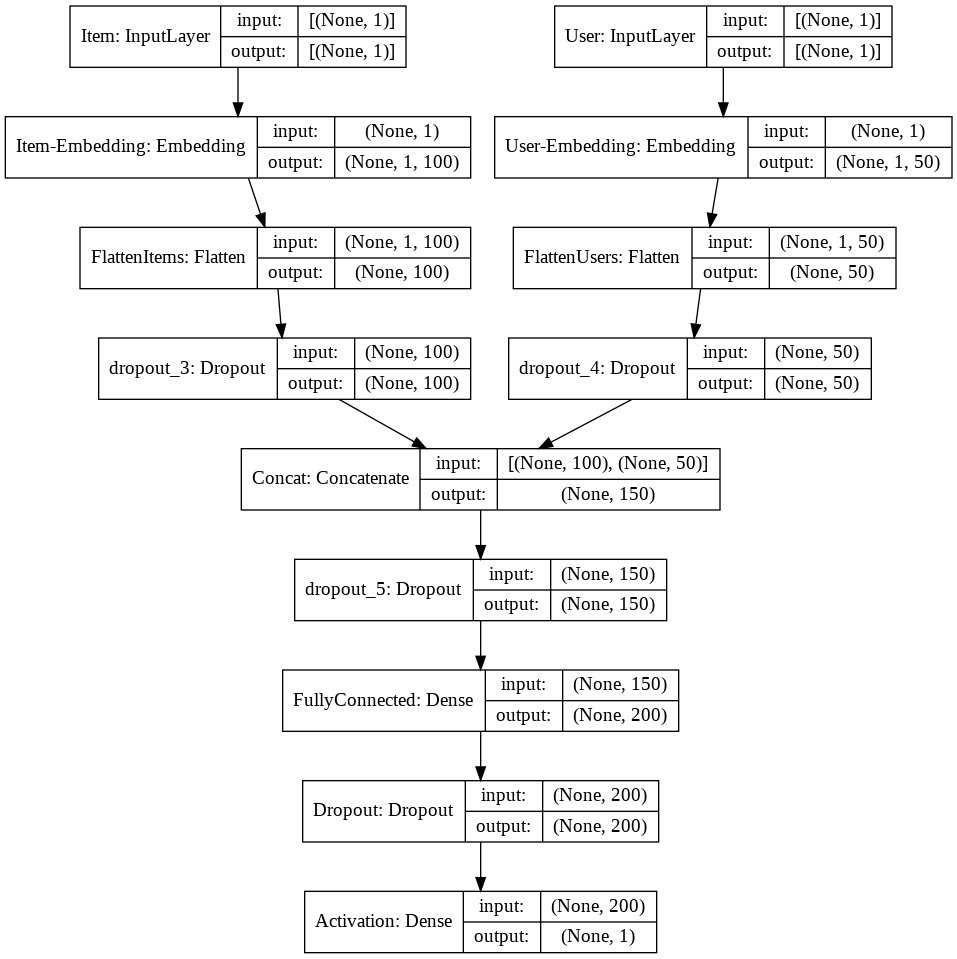

In [0]:
tf.keras.utils.plot_model(model_NN,to_file='model_NN.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [0]:
experiment_name = "NNMF"
err_test = compute_error(model_NN, user_index_test, item_index_test)

precision = compute_precisionAtK_from_recommendations(model_NN, df_test, validation_set=validation_set, \
                                                      nrRecommendations=20, k=5)
print("MF: Precision@{} is {}".format(5, precision))
print("MF: MAE is {}".format(err_test))

table.add(name=experiment_name, mae=err_test, precision=precision, overwrite=True)
table.show()


MF: Precision@5 is 0.044647519582245436
MF: MAE is 0.739405553424872


NameError: ignored

### Question:
Change the model parameters, for example:
- Change the number of layers of the NN
- Remove/add dropout




### Design a simple baseline:  predict average rate per item and recommend items with the highest rating

In [0]:
gbo = df_test[["item", "rate"]].groupby("item").mean().reset_index()
df_gbo = pd.merge(df_test, gbo, on="item", suffixes=('', '_gbo'))
display(df_gbo[df_gbo.item == 1].head())
predicted_rates_gbo_test = df_gbo.rate_gbo.values

err_gbo_test = mean_absolute_error(rates_test + mean_rating_test, predicted_rates_gbo_test)

print("Mean absolute error on the test set: {}".format(err_gbo_test))


### Generate recommendations

In [0]:
def recommend_highest_rates(df, userList, nrRecommendations=10):
    gbo_set = {}
    
    # compute mean rating per item
    all_items = numpy.unique(df['item'].values)
    gbos = df.groupby("item").mean().rate.reset_index().sort_values(by="rate", ascending=False).item.values[:nrRecommendations]
    
    for user in userList:
        gbo_set[user] = gbos
            
    return gbo_set

In [0]:
highest_rates_baseline = recommend_highest_rates(df, validation_set.keys(), nrRecommendations=20)

precision_baseline = precisionAtK(validation_set, highest_rates_baseline, k=5)
print("Baseline: Precision@{} is {}".format(5, precision_baseline))
table.add(name="gbo", mae=err_gbo_test, precision=precision_baseline, overwrite=True)


### Final scores

In [0]:
display(table.df.sort_values(by="MAE"))


In [0]:
display(table.df.sort_values(by="Precision@5", ascending=False))
